based on https://github.com/hardmaru/estool/blob/master/simple_es_example.ipynb

# The Brachistochrone

The Brachistochrone is a physics problem posed by Johann Bernoulli in 1696.

What path gives us the shortest distance between two points? As most people know, in flat space the answer is a line. 

What path gives us the *shortest time* between two points? Assuming we are in a uniform gravitation field, the Brachistochrone curve is the path that minimizes the amount of time it takes to get from point A to point B. What does this Brachistochrone curve look like?

To set up the problem, we assume that point $a$ is located at $(0,0)$, and that point $b$ is at point $(x_f,y_f)$ and all points on the path have $y \leq 0$. Starting with a particle at rest at point $a$, and using conservation of energy $E = T + U$, we know that at point $a$ the total energy is 0, and at any other point $(x,y)$ on the curve, the energy is $\frac{1}{2}mv^2 - mgy = 0$.  From this we get the following equation for the velocity of the particle:

$$ v = \sqrt{2 g y}$$

$s$ is the path the particle takes, so we know $\frac{ds}{dt} = v$. We can then rearrange the equation to get $\frac{ds}{v} = dt$ and integrate to get

$$ \Delta t = \int_a^b \frac{ds}{\sqrt{2 g y}}$$

We can express our goal as trying to find the path $s$ such that $\Delta t$ is minimum. Rearranging the variables we have

$$ \Delta t = \int_a^b \frac{\sqrt{dx^2 + dy^2}}{\sqrt{2 g y}} = \int_0^x \sqrt{\frac{1+ y'(x)}{2 g y}} dx = \int_0^x f\{y,y';x\} dx $$

So $\Delta t$ is a functional (its arguments are functions). We need to find the function $y$ and $y'$ that will minimize its value. Classicaly, this is a problem in the Calculus of Variations. Solving it requires plugging $f$ into the Euler-Lagrange equation and solving the resulting differential equation to find $y$.

$$ \frac{df}{dy} - \frac{d}{dx}\frac{df}{dy'} = 0 \qquad \text{Euler-Lagrange} $$

Plugging in $f$ into the above equation eventually leads to the differential equation of a cycloid.

$$ \left(\frac{dy}{dx}\right)^2 = \frac{2k-y}{y} $$

So in other words, the shape of the Brachistochrone curve is a cycloid. Cycloids cannot be expressed in closed form, but can be expressed in parametric form. 

$$ x = k(\theta-\sin\theta) \qquad y = k(1-\cos\theta) $$

k is the radius of the circle the cycloid is being drawn by. k is found by using the condition that the cycloid must pass through the point $(x_f,y_f)$. 

## Approximating the cycloid 

We can expand the cycloid function in terms of any set of basis functions we want in order to get an approximation of the function and its derivatives.

### Fourier basis 

One possible basis is the fourier basis:

$$ y(x) \approx a_0 + \sum_{i=1}^n a_n \cos{\frac{xn}{2k}} + b_n \sin{\frac{xn}{2k}} \qquad y'(x) \approx \sum_{i=1}^n \frac{n b_n}{2k} \cos{\frac{xn}{2k}} -\frac{n a_n}{2k} \sin{\frac{xn}{2k}} $$

And we can get the fourier coeffcients with the following equation:

$$ a_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x) \cos(\frac{nx}{2 k}) dx \qquad b_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} y(x) \sin(\frac{nx}{2 k}) dx $$

Since we can only express the cycloid parameterically, we change all the variables to $\theta$:

$$ \text{d}x = k(1 -\cos(\theta)) \text{d}\theta \qquad x$$

$$ a_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \cos(\frac{n}{2} (\theta-\sin{\theta})) d\theta \qquad b_n = \frac{k}{2\pi} \int_{-2\pi}^{2\pi}(1-\cos{\theta})^2 \sin(\frac{n}{2} (\theta-\sin{\theta})) d\theta = 0 $$ 

All the $b_n$ will be zero because the cycloid is an even function. We can then plug in this $y(x)$ and $y'(x)$ in our $\Delta t$ equation to actually see what the minimal time is. Of course, to get a good approximation of the cycloid, we will need quite a few terms in the fourier expansion.

### Polynomial basis (Chebyshev)

Another basis is a polynominal basis defined on the interval $[-c,c]$. The Chebyshev expansion of a function can be expressed as 

$$ y(x) \approx c*a_0 + \sum_{i=1}^n c*a_i T_i(x/c) $$
$$ T_1(x/c) = 1 \qquad T_2(x/c) = \frac{x}{c} \qquad T_{n+1}(x/c) = 2\frac{x}{c}T_n(x) - T_{n-1}(x/c)  $$

Where $T_1(x)$ are the Chebyshev polynomials of the first kind. Taking the derivative of the polynomials of the first kind produces the polynomials of the second kind.

$$ \frac{\text{d}T_n(x)}{\text{d}x} = nU_{n-1}(x) \qquad U_1(x) = 1 \quad U_2(x) = 2x \quad U_{n+1}(cx) = 2xU_n(x) - U_{n-1}(x)  $$

So the derivative of $y$ will be 

$$ y'(x) \approx \sum_{i=1}^n a_n i\,U_{i-1}(x/c) $$

In [1]:
import numpy as np
import sys, math
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import cma
from es import SimpleGA, CMAES, PEPG, OpenES

In [2]:
#constants
XBEGIN = 0.0001 #don't start integration from zero-- messes up integrator
YBEGIN = -0.0001 #don't start integration from zero-- messes up integrator
XFINAL = 10.0
YFINAL = -5.
TERMS = 20 #how many terms to include in the expansion
g = -9.8 #m/s^2

# Below are the optimal parameters gotten by solving the parametric equation with Mathematica.
# Can we do the same with ES?
# For reference, Mathematica equation to numerically solve the parametric equation of a cycloid is:
# FindRoot[Evaluate[{K*(t - Sin[TFINAL]) == XFINAL, K*(1 - Cos[TFINAL]) == YFINAL}], {K, 5}, {TFINAL, 3.2}, MaxIterations -> 1000]
K = 2.585999608432 #radius of the cycloid that draws the brachistochrone curve. 
TFINAL = 3.50837   #angle of the cycloid at (XFINAL,YFINAL). 

In [141]:
import scipy.special as special_funcs
C = XFINAL

def get_cheby_path_func(theta):
    order = theta.size
    def f(x):
        cheby = np.array([special_funcs.eval_chebyt(i,x/C) for i in range(order)])
        cheby = np.transpose(cheby)
        return np.dot(cheby,C*theta)
    return f

#use chebyu for the derivative
def get_cheby_path_func_deriv(theta): 
    theta = theta[1:]
    order = theta.size
    def f(x):
        cheby = np.array([(i+1)*special_funcs.eval_chebyu(i,x/C) for i in range(order)])
        cheby = np.transpose(cheby)
        return np.dot(cheby,theta)
    return f

def delta_time(path, path_prime, xb=XBEGIN, xf=XFINAL):
    #equation gotten from conservation of energy
    #due to conservation of energy, values of f(x) > 0 are impossible.
    #they will create a negative inside the sqrt and return an NaN
    def functional(x):
        p = path(x)
        if p > 0:
            p = -0.00000001
        result = np.sqrt((1+path_prime(x)**2)/(2.0*g*p))
        return result
    time = integrate.quad(functional,xb,xf,limit=200)[0] 
    return time

In [234]:
# What are the chebyshev coefficients for the ideal cycloid path? 
#n is the number of coefficients to approx with
# x = k(deg-sin(deg)); y = k(1-cos(deg))
# dx = k(1-cos(deg))d(deg)
# limits are 1 - deg = sin(deg)
lim = 3.50837

def cheby_cycloid_coefficients(n):
    def f(deg,i):
        x = (K/C)*(deg-np.sin(deg))
        y = (K/C)*(1-np.cos(deg))
        coef = 1./(C*np.pi) if i == 0 else 2./(C*np.pi)
        cheby = special_funcs.eval_chebyt(i,x)
        results = (coef*cheby*(y**2))/np.sqrt(1-x**2)
        return results
    thetas = [integrate.quad(lambda x: f(x,j),lim,-lim,limit=200)[0] for j in range(n)]
    return thetas

In [235]:
a = cheby_cycloid_coefficients(20)
b = get_cheby_path_func(np.array(a))
c = get_cheby_path_func_deriv(np.array(a))
print(a)
print(b(.0001))
print(b(10))
print(c(10))

[-0.044442696873506306, -0.0, -0.011447188632346877, -0.0, 0.008658537392531045, -0.0, -0.0044668242738176555, -0.0, 0.002855195474102763, -0.0, -0.0020064688185464684, -0.0, 0.0014978925121412474, -0.0, -0.001173656592045836, -0.0, 0.0009110581607894403, -0.0, -0.0007810377769037651, -0.0]
-0.1064483732330774
-0.5039518942760242
-0.12013772246576382


/usr/local/anaconda3/envs/handsonml/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


In [228]:
'''stuff for fourier series implementation

def cycloid_coefficients(n):
    # n is number of sine coefficients and n+1 the number of cosine coeffcieints. 
    # change of variables to theta is necessary since cannot write in terms of y(x).
    # sine terms are all 0. cosine terms are non-zero.
    coefs = [0]*(2*n+1)
    def cos_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.cos((c/2.)*(theta-np.sin(theta))))
    def sin_coef(c,theta):
        return ((1-np.cos(theta))**2)*(np.sin((c/2.)*(theta-np.sin(theta))))
    for i in range(n):
        coefs[2*i] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(i,x),-2*np.pi,2*np.pi,limit=200)[0]
        coefs[2*i+1] = 0
    coefs[0] = coefs[0]/2.0
    coefs[2*n] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(n,x),-2*np.pi,2*np.pi,limit=200)[0]
    return np.array(coefs)

def fourier_y(c_list):
    # Given a list of coefficients c_list, f(x) is the fourier expansion. 
    # f(x) = a0 + sum(an*cos(nx) + bn*sin(nx))
    # even entries in c_list are the a_n, odd entries are the b_n. 
    #c_list should always have odd len(c_list).
    a = c_list[::2]
    b = c_list[1::2]
    def f(x):
        cosines = np.array([np.cos(x*n/(2.*K)) for n in range(len(a))])
        sines = np.array([np.sin(x*n/(2.*K)) for n in range(1,len(b)+1)])
        result = (np.dot(a,cosines)+np.dot(b,sines))
        # the result cannot have f(x) > 0 due to conservation of energy
        if np.isscalar(result):
            return result if result < 0 else -0.00001
        return np.array([i if i < 0 else -0.00001 for i in result])
    return f

def fourier_yp(c_list,x):
    #derivative of the function f(x)
    #f' = sum(n*bn*cos(nx)-n*an*sin(nx))
    a = c_list[::2]
    b = c_list[1::2]
    cosines = np.array([(n/(2.*K))*np.cos(x*n/(2.*K)) for n in range(1,len(b)+1)])
    sines = np.array([-(n/(2.*K))*np.sin(x*n/(2.*K)) for n in range(1,len(a))])
    result = np.dot(a[1:],sines)+np.dot(b,cosines)
    return result
'''

"stuff for fourier series implementation\n\ndef cycloid_coefficients(n):\n    # n is number of sine coefficients and n+1 the number of cosine coeffcieints. \n    # change of variables to theta is necessary since cannot write in terms of y(x).\n    # sine terms are all 0. cosine terms are non-zero.\n    coefs = [0]*(2*n+1)\n    def cos_coef(c,theta):\n        return ((1-np.cos(theta))**2)*(np.cos((c/2.)*(theta-np.sin(theta))))\n    def sin_coef(c,theta):\n        return ((1-np.cos(theta))**2)*(np.sin((c/2.)*(theta-np.sin(theta))))\n    for i in range(n):\n        coefs[2*i] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(i,x),-2*np.pi,2*np.pi,limit=200)[0]\n        coefs[2*i+1] = 0\n    coefs[0] = coefs[0]/2.0\n    coefs[2*n] = -1.0*(K/(2.*np.pi))*integrate.quad(lambda x: cos_coef(n,x),-2*np.pi,2*np.pi,limit=200)[0]\n    return np.array(coefs)\n\ndef fourier_y(c_list):\n    # Given a list of coefficients c_list, f(x) is the fourier expansion. \n    # f(x) = a0 + sum(an*cos(nx) +

/usr/local/anaconda3/envs/handsonml/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  


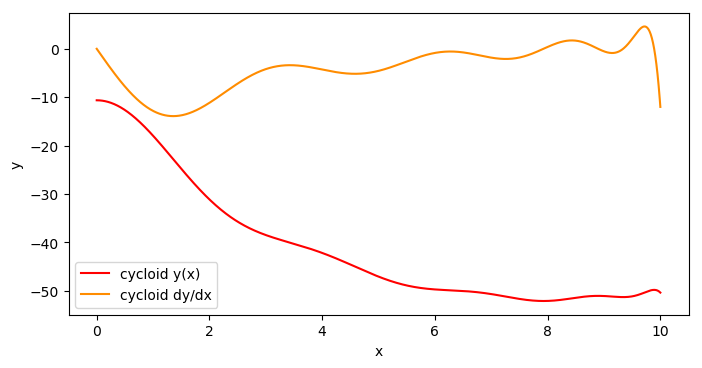

Delta t: 1.9743860485041633 s


In [229]:
%matplotlib inline

xaxis = np.linspace(XBEGIN, XFINAL, 1000)
thetas = cheby_cycloid_coefficients(TERMS)
thetas = np.array(thetas).reshape(-1,1)
func = get_cheby_path_func(thetas)
deriv_func = get_cheby_path_func_deriv(thetas)
plt.figure(figsize=(8,4), dpi=100)
y_points, = plt.plot(xaxis, func(xaxis), color="red",label='cycloid y(x)')
yp_points, = plt.plot(xaxis, deriv_func(xaxis), color="darkorange",label='cycloid dy/dx')
plt.legend(handles=[y_points, yp_points], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print('Delta t:',delta_time(func,deriv_func),'s')

# Alternative functions

To see how other functions compare to the optimal cycloid, we can decompose them into their fourier coeffcients and plug them into $\Delta t$ just the same. One such example is the straight line that connects $a = (0,0)$ to $b  = (x_f,y_f)$. The coeffcients for the line are:


$$ a_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} \frac{y_f}{x_f}x \cos(\frac{nx}{2 k}) dx = 0 \qquad b_n = \frac{1}{2\pi k} \int_{-2\pi k}^{2\pi k} \frac{y_f}{x_f}x \sin(\frac{nx}{2 k}) dx $$

All the $a_n$ will be zero because the line is an odd function. If we use few terms in the fourier expansion, the result will not look like a straight line.

In [224]:
# What are the chebyshev coefficients for a line? 
def cheby_line_coefficients(n):
    def f(x,i):
        u = x/C
        y = -0.5*u
        coef = 1./(C*np.pi) if i == 0 else 2./(C*np.pi)
        cheby = special_funcs.eval_chebyt(i,u)
        results = (coef*cheby*y)/np.sqrt(1-(u**2))
        return results
    thetas = [integrate.quad(lambda x: f(x,j),-C,C,limit=200)[0] for j in range(n)]
    return thetas

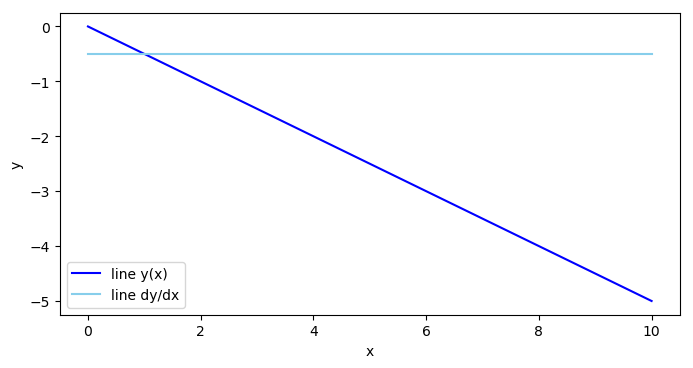

Delta t: 2.2516269000305043 s


In [225]:
xaxis = np.linspace(XBEGIN, XFINAL, 1000)
thetas = cheby_line_coefficients(TERMS)
thetas = np.array(thetas).reshape(-1,1)
func = get_cheby_path_func(thetas)
deriv_func = get_cheby_path_func_deriv(thetas)
plt.figure(figsize=(8,4), dpi=100)
y_points, = plt.plot(xaxis, func(xaxis), color="blue",label='line y(x)')
yp_points, = plt.plot(xaxis, deriv_func(xaxis), color="skyblue",label='line dy/dx')
plt.legend(handles=[y_points, yp_points], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()
print('Delta t:',delta_time(func,deriv_func),'s')

# Evolution Strategies and the Brachistochrone

Rather than using the Euler-Lagrange equation to solve the problem, we can use ML to find the optimal curve. Essentially we will try to minimize the $\Delta t$ function by crawing around in fourier space until we find the coefficients that return the minimum function.

A random set of fourier coefficients will create a random curve. This curve may go above the $y=0$ line, which violates conservation of energy. A random curve will also likely not respect the boundry conditions of $a = (0,0)$ and $b  = (x_f,y_f)$. If we want to use an ML algorithm to find the brachistochrone curve, we need to create a reward function that uses the $\Delta t$ function as a basis, and then has extra terms that heavily penalizes curves that do not follow the boundry conditions and conservation of energy. 

We can then use this new reward function as the fit function for the CMA-ES or OpenAI-ES algorithms. Fourier coefficients that return a lower $\Delta t$ and respect the laws of nature will recieve a higher reward and pass on their coefficients to the next generation. 

For the case where we are using few fourier coefficients, the approximation of the cycloid may not be optimal, and the ES alogorithms may very well do better than our benchmark.

In [ ]:
def cost_function(c_list):
    c_list = np.copy(c_list)
    def cost(x):
        #equation gotten from conservation of energy
        #due to conservation of energy, values of f(x) > 0 are impossible.
        #they will create a negative inside the sqrt and return an NaN
        return np.sqrt((1+fourier_yp(c_list,x)**2)/(2.0*g*fourier_y(c_list,x)))
    time = integrate.quad(cost,0.0001,XFINAL,limit=200)[0] #don't start integration from zero-- messes up integrator.
    #we also want to constrain the path to begin at (XBEGIN,YBEGIN) and end at (XFINAL,YFINAL)
    #i.e. F(XBEGIN;theta) - YBEGIN = 0 and F(XFINAL;theta) - YFINAL = 0
    begin_penalty = math.fabs(fourier_y(c_list,XBEGIN)-YBEGIN)**3
    end_penalty = math.fabs(fourier_y(c_list,XFINAL)-YFINAL)**3
    return -1.*time-begin_penalty-end_penalty

fit_func = cost_function

In [ ]:
NPARAMS = (FOURIER_TERMS*2)+1 #Our parameters are all our fourier coefficients
NPOPULATION = 50    # use population size of 50.
MAX_ITERATION = 200 # run each solver for 300 generations.

In [ ]:
rand_coefs = np.random.randn(NPARAMS)
yaxis_rand = fourier_y(rand_coefs,xaxis)
plt.figure(figsize=(8,4), dpi=100)
rand_y, = plt.plot(xaxis, yaxis_rand, color="green",label='rand y(x)')
line_y, = plt.plot(xaxis, yaxis_line, color="blue",label='line y(x)')
optimal_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
plt.legend(handles=[optimal_y,line_y, rand_y], loc=3)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('LINE:')
print('  fitness:',cost_function(line_coefs))
print('RANDOM:')
print('  fitness:',cost_function(rand_coefs))

In [ ]:
# defines a function to use solver to solve fit_func
def test_solver(solver):
    history = []
    for j in range(MAX_ITERATION):
        solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        for i in range(solver.popsize):
            fitness_list[i] = fit_func(solutions[i])
        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append((result[0],result[1]))
        if (j) % 2 == 0:
            print("fitness at iteration", (j), result[1])
    print("fitness score at this local optimum:", result[1])
    return history

In [ ]:
# defines CMA-ES algorithm solver
cmaes = CMAES(NPARAMS,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = 0.2
          )

In [ ]:
cma_history = test_solver(cmaes)


In [ ]:
cma_coefs = cma_history[-1][0]
plt.figure(figsize=(16,8), dpi=150)
for i in range(len(cma_coefs)-1):
    yaxis_temp = fourier_y(cma_history[i][0],xaxis)
    plt.plot(xaxis, yaxis_temp, color=(0.0, 1.0-(i/len(cma_coefs)), (i/len(cma_coefs))),alpha=0.05+0.15*(i/len(cma_coefs)))
yaxis_cma = fourier_y(cma_coefs,xaxis)
cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
cma_y, = plt.plot(xaxis, yaxis_cma, color="orange",label='CMA-ES y(x)')
plt.legend(handles=[cycloid_y,cma_y], loc=3)
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('CMA-ES:')
print('  fitness:',cost_function(cma_coefs))

In [ ]:
# defines OpenAI's ES algorithm solver. Note that we needed to anneal the sigma parameter
oes = OpenES(NPARAMS,                  # number of model parameters
            sigma_init=0.5,            # initial standard deviation
            sigma_decay=0.999,         # don't anneal standard deviation
            learning_rate=0.1,         # learning rate for standard deviation
            learning_rate_decay = 1.0, # annealing the learning rate
            popsize=NPOPULATION,       # population size
            antithetic=False,          # whether to use antithetic sampling
            weight_decay=0.00,         # weight decay coefficient
            rank_fitness=False,        # use rank rather than fitness numbers
            forget_best=False)

In [ ]:
oes_history = test_solver(oes)

In [ ]:
oes_coefs = oes_history[-1][0]
plt.figure(figsize=(16,8), dpi=150)
for i in range(len(oes_coefs)-1):
    yaxis_temp = fourier_y(oes_history[i][0],xaxis)
    plt.plot(xaxis, yaxis_temp, color=(0.0, 1.0-(i/len(cma_coefs)), (i/len(cma_coefs))),alpha=0.05+0.15*(i/len(cma_coefs)))
yaxis_oes = fourier_y(oes_coefs,xaxis)
cycloid_y, = plt.plot(xaxis, yaxis_cycloid, color="red",label='cycloid y(x)')
oes_y, = plt.plot(xaxis, yaxis_oes, color="orange",label='OpenAI-ES y(x)')
plt.legend(handles=[cycloid_y,oes_y], loc=3)
plt.show()

print('CYCLOID:')
print('  fitness:',cost_function(cycloid_coefs))
print('OpenAI-ES:')
print('  fitness:',cost_function(oes_coefs))

In [ ]:
cycloid_fitness = [-cost_function(cycloid_coefs)] * MAX_ITERATION
plt.figure(figsize=(16,8), dpi=150)

oes_fitness = [-i[1] for i in oes_history ]
cma_fitness = [-i[1] for i in cma_history ]

cycloid_line, = plt.semilogy(cycloid_fitness, color="black", linewidth=0.5, linestyle="-.", label='Cycloid Fit')
oes_line, = plt.semilogy(oes_fitness, color="green", linewidth=1.0, linestyle="-", label='OpenAI-ES')
cma_line, = plt.semilogy(cma_fitness, color="blue", linewidth=1.0, linestyle="-", label='CMA-ES')

plt.legend(handles=[cycloid_line, cma_line, oes_line], loc=1)

# Set x limits
#plt.xlim(0,2500)

plt.xlabel('generation')
plt.ylabel('-1*fitness')

# plt.savefig("./rastrigin_10d.svg")

plt.show()